In [1]:
import numpy as np
from scipy.special import lambertw
from scipy.optimize import brentq
from astropy.table import Table
import astropy.units as u
from matplotlib import pyplot as plt


In [2]:
# Sources to consider
all_sources = ['comaberenices', 'draco', 'segue1', 'ursamajor2']

def load_source_ul_ecsv(path, mass_unit=u.TeV):
    """
    Load a single-source UL curve from the ECSV you described.
    Returns (mDM [Quantity], ul [ndarray]) sorted by mass.
    """
    t = Table.read(path)
    m = np.array(t[t.colnames[0]], dtype=float)
    ul = np.array(t[t.colnames[1]], dtype=float)

    idx = np.argsort(m)
    return (m[idx] * mass_unit), ul[idx]


def combine_uls_lognormal(
    ul,
    sigma_log10J,
    sigma_log10J_new=None,
    cl_lambda=2.71,
    J0=1.0,
    x_max=1e6,

):
    """
    Combine single-target ULs for multiple targets by reconstructing A_i from each UL,
    then solving q_tot(x)=lambda using (possibly) *different* sigma values for the
    combination.

    Parameters
    ----------
    ul : array-like
        Single-target ULs x_UL,i (same CL lambda), one per target, at a fixed mass.
    sigma_log10J : array-like or None
        sigma(log10 J) values that were assumed for the *input ULs*.
    sigma_log10J_new : array-like
        sigma(log10 J) values to use for the *combination* (B_i and eps_i(x)).
        If None, defaults to sigma_log10J (backward compatible).
    cl_lambda : float
        Threshold lambda (2.71 for one-sided 95% in Wilks/Wald).
    J0 : float or array-like
        Central value(s) J0,i. Scalar or per-target.
    x_max : float
        Max search scale for bracketing.


    Returns
    -------
    x_comb : float
        Combined UL solving q_tot(x)=lambda.
    """
    ul = np.asarray(ul, dtype=float)
    sigma_log10J = np.asarray(sigma_log10J, dtype=float)

    if sigma_log10J is None:
        sigma_log10J = sigma_log10J_new
    sigma_log10J_new = np.asarray(sigma_log10J_new, dtype=float)

    if ul.shape != sigma_log10J.shape or ul.shape != sigma_log10J_new.shape:
        raise ValueError("ul, sigma_log10J, and sigma_log10J_new must have the same shape")
    if np.any(~np.isfinite(ul)) or np.any(ul <= 0):
        raise ValueError("All ULs must be finite and positive")
    if np.any(~np.isfinite(sigma_log10J)) or np.any(sigma_log10J <= 0):
        raise ValueError("All sigma_log10J must be finite and > 0")
    if np.any(~np.isfinite(sigma_log10J_new)) or np.any(sigma_log10J_new <= 0):
        raise ValueError("All sigma_log10J_new must be finite and > 0")

    # allow scalar J0 or per-target
    J0 = np.asarray(J0, dtype=float)
    if J0.size == 1:
        J0 = np.full_like(ul, float(J0))
    if J0.shape != ul.shape:
        raise ValueError("J0 must be scalar or have the same shape as ul")

    # Convert sigmas
    sigma_lnJ  = sigma_log10J  * np.log(10.0)   # used ONLY to reconstruct A
    sigma_lnJ_new = sigma_log10J_new * np.log(10.0)   # used in combination

    # ---- Step 1: reconstruct A_i from the *input ULs* using sigma_ul ----
    eps_ul = 0.5 * (np.sqrt(1.0 + 4.0 * cl_lambda * sigma_lnJ**2) - 1.0)

    # A = [ (sqrt(eps)/sigma)*exp(eps) / (J0*x_UL) ]^2   (sigma here is sigma_ul)
    A = (((np.sqrt(eps_ul) / sigma_lnJ) * np.exp(eps_ul)) / (J0 * ul))**2

    # ---- Step 2: define combined test statistic using sigma_use ----
    B = 1.0 / (sigma_lnJ_new**2)

    def q_tot(log10x):
        x = 10.0**log10x
        arg = 2.0 * A * (J0**2) * (x**2) / B
        eps_x = 0.5 * lambertw(arg).real
        return np.sum(B * eps_x * (1.0 + eps_x))

    def f(log10x):
        return q_tot(log10x) - cl_lambda

    lo = -100.0
    hi = np.log10(np.max(ul)) + 2.0
    if not np.isfinite(hi) or hi <= lo:
        hi = 1.0

    # bracket
    for _ in range(80):
        if f(hi) > 0:
            break
        hi *= 2.0
        if hi > np.log10(x_max):
            return np.nan

    # return UL in linear x units
    log10x_star = brentq(f, lo, hi, xtol=1e-2, rtol=1e-10, maxiter=500)
    return 10.0**log10x_star


def combine_ul_curves(
    sources,
    file_template="MAGIC_multi/magic_2022_{source}_ann_tautau.ecsv",
    sigma_log10J_map=None,          # sigma assumed for the input UL curves (baseline)
    sigma_log10J_map_new=None,       # sigma used for combination (new)
    cl_lambda=2.71,
    mass_unit=u.TeV,
    grid="overlap",
):
    if sigma_log10J_map is None:
        raise ValueError("Provide sigma_log10J_map={source: sigma_log10J} (used for original ULs).")

    # If not provided, assume UL sigma == combination sigma 
    if sigma_log10J_map_new is None:
        sigma_log10J_map_new = sigma_log10J_map

    for s in sources:
        if s not in sigma_log10J_map:
            raise ValueError(f"Missing sigma_log10J (use) for source '{s}' in sigma_log10J_map.")
        if s not in sigma_log10J_map_new:
            raise ValueError(f"Missing sigma_log10J (UL) for source '{s}' in sigma_log10J_map_new.")

    # Load all curves
    curves = {}
    for s in sources:
        m, ul = load_source_ul_ecsv(file_template.format(source=s), mass_unit=mass_unit)
        curves[s] = (m, ul)

    # Define mass grid
    if isinstance(grid, str):
        if grid == "overlap":
            m_min = max(curves[s][0].min().to_value(mass_unit) for s in sources)
            m_max = min(curves[s][0].max().to_value(mass_unit) for s in sources)
            m_grid = np.logspace(np.log10(m_min), np.log10(m_max), 200) * mass_unit
        elif grid == "union":
            all_m = np.unique(np.concatenate([curves[s][0].to_value(mass_unit) for s in sources]))
            m_grid = all_m * mass_unit
        else:
            raise ValueError("grid must be 'overlap', 'union', or an explicit Quantity array.")
    else:
        m_grid = grid.to(mass_unit)

    # Interpolate UL curves on grid in log-log space
    ul_interp = {}
    for s in sources:
        m, ul = curves[s]
        x = np.log10(m.to_value(mass_unit))
        y = np.log10(ul)
        xg = np.log10(m_grid.to_value(mass_unit))

        ul_g = np.full_like(xg, np.nan, dtype=float)
        mask = (xg >= x.min()) & (xg <= x.max())
        ul_g[mask] = 10 ** np.interp(xg[mask], x, y)

        ul_interp[s] = ul_g

    # Combine point-by-point
    ul_comb = np.full(m_grid.size, np.nan, dtype=float)

    sigma = np.array([sigma_log10J_map[s] for s in sources], dtype=float)
    sigma_new = np.array([sigma_log10J_map_new[s] for s in sources], dtype=float)

    for i in range(m_grid.size):
        uls_here = np.array([ul_interp[s][i] for s in sources], dtype=float)
        ok = np.isfinite(uls_here)
        if np.sum(ok) >= 1:
            ul_comb[i] = combine_uls_lognormal(
                uls_here[ok],
                sigma_log10J=sigma[ok],
                sigma_log10J_new=sigma_new[ok],
                cl_lambda=cl_lambda,
            )

    return m_grid, ul_comb, ul_interp

In [3]:




# Old sigma(log10 J) values that were assumed for the published UL curves:
sigma_log10J_map = {
    'comaberenices': 0.41,
    'draco': 0.21,
    'segue1': 0.42,
    'ursamajor2': 0.35,
}

# New sigma(log10 J) values to use in the combination:
# Example:
#sigma_log10J_map_new = {
#    'comaberenices': 0.05,
#    'draco': 0.018,
#    'segue1': 0.02,
#    'ursamajor2': 0.01,
#}

# Or put it to None if you want to assume the same sigmas as before:
sigma_log10J_map_new = None


m_grid, ul_comb_new, ul_interp = combine_ul_curves(
    all_sources,
    file_template="MAGIC_multi/magic_2022_{source}_ann_tautau.ecsv",
    sigma_log10J_map     = sigma_log10J_map,      # used to reconstruct A from published UL
    sigma_log10J_map_new = sigma_log10J_map_new,   # used in combination
    grid="overlap",
    cl_lambda=2.71,
    mass_unit=u.GeV
)

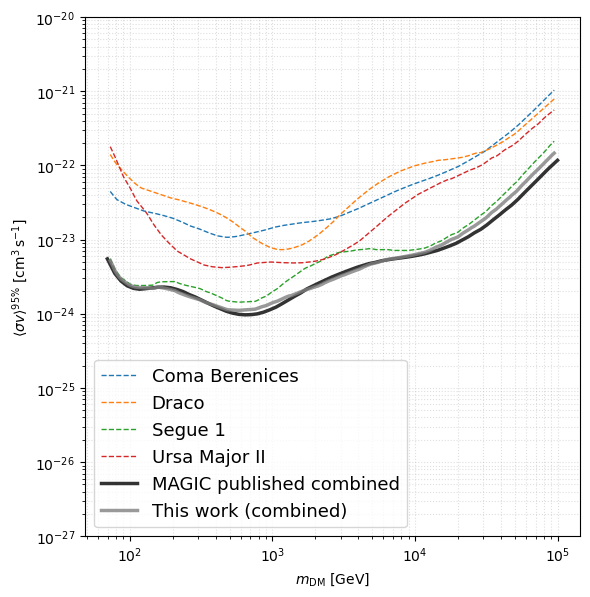

In [4]:
# --- load published combined UL (MAGIC) ---
t_pub = Table.read("MAGIC_multi/magic_2022_multidsph_ann_tautau.ecsv")
m_pub = np.array(t_pub[t_pub.colnames[0]], dtype=float) * u.GeV
ul_pub = np.array(t_pub[t_pub.colnames[1]], dtype=float)

idx = np.argsort(m_pub)
m_pub = m_pub[idx]
ul_pub = ul_pub[idx]

# --- plot: individual sources, published combined, your combined ---
plt.figure(figsize=(6,6))
# individual targets (interpolated on m_grid)
all_labels =  ['Coma Berenices', 'Draco', 'Segue 1', 'Ursa Major II']
for i,s in enumerate(all_sources):
    plt.loglog(m_grid.to_value(u.GeV), ul_interp[s], linestyle="--", alpha=1, linewidth=1, label=all_labels[i])

# published combined (as in MAGIC paper)
plt.loglog(m_pub.to_value(u.GeV), ul_pub, linewidth=2.5,alpha=0.8,label="MAGIC published combined",color='black')

# your combined
plt.loglog(m_grid.to_value(u.GeV), ul_comb_new, linewidth=2.5, linestyle="-", label="This work (combined)", color='grey',alpha=0.8)

plt.xlabel(r"$m_{\rm DM}\ [{\rm GeV}]$")
plt.ylabel(r"$\langle\sigma v\rangle^{95\%}\ [{\rm cm^3\,s^{-1}}]$")  # adjust units if needed
plt.legend(fontsize=13)
plt.grid(True, which="both", ls=":", alpha=0.4)
plt.tight_layout()

plt.ylim(1e-27, 1e-20)
plt.savefig("combined_ULs.png", dpi=300)
